# 수집된 데이터에 대한 통계 분석
* 데이터 
> 2017년 12월 1일부터 2018년 1월 1일까지 32일간 [네이버](http://www.naver.com)와 [다음](http://www.daum.net)의 랭킹뉴스와 뉴스의 댓글을 크롤링함.

In [236]:
import os
import pandas as pd 
from glob import glob
import sys
import time, re, pickle, itertools
import urllib3, json
sys.path.append('~/Documents/GitHub/Private_Project/personal_project/')
import re
from operator import itemgetter
import html
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import chat_bot as cb
import Database_Handler as dh
from datetime import datetime
import seaborn as sns
import functools
%matplotlib inline

In [3]:
def LoadDatabase(site):
    import Database_Handler as dh
    if site == 'daum':
        collection = 'newsDaum'
    elif site.lower() == 'naver':
        collection = 'newsNaver'
    mongodb = dh.ToMongoDB(*dh.AWS_MongoDB_Information())
    dbname = 'hy_db'
    useDb = dh.Use_Database(mongodb, dbname)
    useCollection = dh.Use_Collection(useDb, collection)
    collection = useCollection.find({'site':site})
    dataDict = dict()
    for data in collection:
        dataDict[data['_id']._ObjectId__id.hex()] = idData = dict()
        idData['category'] = data['category']
        idData['date'] = data['date']
        idData['press'] = data['press']
        idData['number_of_comment'] = data['number_of_comment']
        idData['number_of_crawled_comment'] = data['real_number_of_comment']
    return dataDict

In [4]:
naver = LoadDatabase('Naver')
daum = LoadDatabase('daum')

In [8]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
def OS_Driver(os,browser):
    if os.lower() == 'windows':
        if browser.lower() == 'phantom':
            driver = webdriver.PhantomJS('C:/Users/pc/Documents/phantomjs-2.1.1-window/bin/phantomjs.exe')
        else:
            driver = webdriver.Chrome('C:/Users/pc/Documents/chromedriver.exe')
    elif os.lower() == 'mac':
        if browser.lower() == 'phantom':
            driver = webdriver.PhantomJS(
                '/Users/hyunyoun/Documents/GitHub/Private_Project/phantomjs-2.1.1/bin/phantomjs')
        else:
            driver = webdriver.Chrome('/Users/hyunyoun/Documents/GitHub/Private_Project/chromedriver')
    return driver
web = 'http://news.naver.com/'
driver = OS_Driver('mac', 'chrome')
driver.get(web)
driver.find_element_by_id('index.press.btn').click()
x = driver.find_element_by_id('index.press.area')
x2 = x.find_element_by_class_name('index_content')
x3 = x2.find_elements_by_css_selector('div')
naverpressdict = dict()
for idx in x3:
    cat = idx.find_elements_by_css_selector('h5')
    sub = idx.find_elements_by_css_selector('ul')
    y = list(zip(list(map(lambda x: re.sub('[\[\]]','',x.text), cat)), list(map(lambda x: x.text.split('\n'), sub))))
    for key, value in y:
        naverpressdict[key] = value
driver.quit()

In [18]:
naverenrolledPress = list()
for idx in naverpressdict:
    naverenrolledPress.append((idx.strip(), len(naverpressdict[idx])))
naverenrolledPress = pd.DataFrame(naverenrolledPress)
naverenrolledPress.rename(columns={0:'category',1:'count'},inplace = True)
naverenrolledPress.set_index('category', inplace = True)
naverenrolledPress

,count
category,
종합,10
방송/통신,14
경제,10
인터넷,6
IT,6
스포츠/연예,50
매거진,16
지역,3
전문지,7


In [180]:
naverPressList = list(itertools.chain.from_iterable(naverpressdict.values()))
naverPress = pd.DataFrame({'NAVER':naverPressList})

In [17]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
web = 'http://media.daum.net/cp/'
res = requests.get(web)
soup = BeautifulSoup(res.content, 'html.parser')
x1 = soup.find('div',class_='box_etc')
x2 = x1.find_all('div', class_='item_cp')

daumpressdict = dict()
count = 0 
for i in x2:
    key = i.find('h4').text
    values = i.find_all('li')
    count += len(values)
    values = list(map(lambda x: x.text.strip(), values))
    daumpressdict[key] = values
print (count)

daumenrolledPress = list()
for idx in daumpressdict:
    daumenrolledPress.append((idx.strip(), len(daumpressdict[idx])))
daumenrolledPress = pd.DataFrame(daumenrolledPress)
daumenrolledPress.rename(columns={0:'category',1:'count'},inplace = True)
daumenrolledPress.set_index('category', inplace = True)
daumenrolledPress

156


,count
category,
종합,14
경제,10
온라인.인터넷,6
TV.동영상,12
스포츠.연예,24
스포츠 전문지,30
IT,8
매거진,41
전문지,7


In [177]:
daumPressList = list(itertools.chain.from_iterable(daumpressdict.values()))
daumPress = pd.DataFrame({'DAUM':daumPressList})

# 네이버와 다음에서 공통적으로 등록된 언론사

* 네이버와 다음에서 언론사를 분류한 카테고리가 다르다.
> 다음은 스포츠 관련하여 스포츠/연예, 스포츠 전문지로 구분한 반면, 네이버는 스포츠/연예로 단일 분류함  
> 네이버는 방송/통신으로 분류하였지만, 다음은 TV.동영상으로 분류함.  
> 네이버는 인터넷으로 분류하였지만, 다음은 온라인.인터넷으로 분류함.  
* 네이버는 정치, 경제, 사회, 생활/문화, 세계, IT/과학, 연예, 스포츠 별로 30개씩 랭킹을 매기고 총 240개씩 수집을 할 수 있으나, 다음은 뉴스, 연예, 스포츠 별로 50개씩 랭킹을 매기고 총 150개씩 수집을 할 수 있다.
> 앞서, 랭킹뉴스에 많이 올라간 언론사 top3를 구했을때, 네이버에서는 통신사인 연합뉴스, 뉴스1, 뉴시스였으나, 다음은 OSEN, 연합뉴스, 뉴스1이었다.  
> 다음에서 OSEN이 가장 많았던 것은 위와 같은 이유가 들어있지 않냐는 생각이다.  
* 언론사의 표기가 약간 다른 것이 존재함

In [308]:
match = pd.DataFrame({'NAVER':['KBS 뉴스', 'KBS 연예', 'MBC 뉴스', 'SBS 뉴스', 'ZDNet Korea', 'SBS CNBC', '아이즈 ize']
,'DAUM':['KBS', 'KBS', 'MBC', 'SBS', '지디넷코리아', 'SBSCNBC', 'ize']})
match

,DAUM,NAVER
0,KBS,KBS 뉴스
1,KBS,KBS 연예
2,MBC,MBC 뉴스
3,SBS,SBS 뉴스
4,지디넷코리아,ZDNet Korea
5,SBSCNBC,SBS CNBC
6,ize,아이즈 ize


In [309]:
intersectPress = set(naverPressList) & set(daumPressList)
print ('naver와 daum에 공통적으로 있는 언론사의 수 : {}'.format(len(intersectPress)+ 6))

naver와 daum에 공통적으로 있는 언론사의 수 : 91


In [310]:
naver_df = pd.DataFrame.from_dict(naver,orient='index')
naver_df['date'] = pd.to_datetime(naver_df['date']).dt.date
naver_df.reset_index(inplace = True)
naver_df.rename(columns={'index':'id'}, inplace=True)
daum_df = pd.DataFrame.from_dict(daum,orient='index')
daum_df['date'] = pd.to_datetime(daum_df['date']).dt.date
daum_df.reset_index(inplace = True)
daum_df.rename(columns={'index':'id'}, inplace=True)

In [311]:
intersectNaver = pd.concat([pd.Series(list(intersectPress)),match['NAVER']])
intersectDaum = pd.concat([pd.Series(list(intersectPress)),match['DAUM']])
intersectDaum.drop_duplicates(inplace = True)

In [312]:
xdict = dict()
for idx in match.index:
    xdict[match.loc[idx,'NAVER']] = match.loc[idx,'DAUM']

In [348]:
naverGroup = naver_df.groupby('press').count()['id'][intersectNaver]
rawNaverIndex = naverGroup.index
naverGroup.rename(index=xdict,inplace = True)
naverGroup = naverGroup.groupby(naverGroup.index).sum()
daumGroup = daum_df.groupby('press').count()['id'][intersectDaum]

In [349]:
naverGroup.index.difference(daumGroup.index)
# 제대로 변경된 것을 확인

Index([], dtype='object')

In [327]:
intersectPress = pd.DataFrame({'DAUM':daumGroup,
                               'DAUM_prop':daumGroup.divide(daum_df.shape[0]),
                               'NAVER':naverGroup, 
                               'NAVER_prop':naverGroup.divide(naver_df.shape[0])}).fillna(0)

In [403]:
intersectPress.sum(axis = 0)

DAUM          4419.000000
DAUM_prop        0.935832
NAVER         7393.000000
NAVER_prop       0.962505
dtype: float64

* 네이버와 다음에 공통적으로 등록된 언론사가 랭킹뉴스에 등록된 신문기사의 90%이상을 차지한다

수집기간동안 랭킹뉴스에 많이 등록된 언론사
rank : 1 [ daum : OSEN] 스포츠.연예 [ naver : 연합뉴스 ] 방송/통신 
rank : 2 [ daum : 연합뉴스] 종합 [ naver : 뉴스1 ] 방송/통신 
rank : 3 [ daum : 뉴스1] 종합 [ naver : 뉴시스 ] 방송/통신 


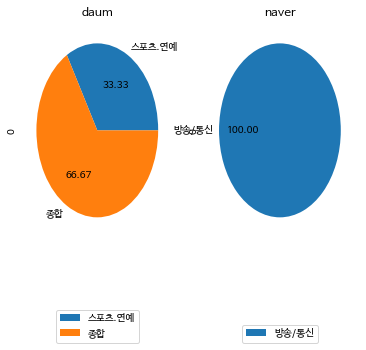

In [401]:
print ('수집기간동안 랭킹뉴스에 많이 등록된 언론사')
daumCat = list()
naverCat = list()
for idx in range(3):
    daumPressOut = intersectPress.sort_values(by='DAUM_prop',ascending=False).index[idx]
    for key in daumpressdict:
        if daumPressOut in daumpressdict[key]:
            cat1 = key
            break
    daumCat.append(cat1)
    naverPressOut = intersectPress.sort_values(by='NAVER_prop',ascending=False).index[idx]
    for key in naverpressdict:
        if naverPressOut in naverpressdict[key]:
            cat2 = key
            break
    naverCat.append(cat2)
    print ('rank : {} [ daum : {}] {} [ naver : {} ] {} '.format(idx+1, daumPressOut, cat1, naverPressOut, cat2))

ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(daumCat),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(naverCat),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

수집기간동안 랭킹뉴스에 많이 등록된 언론사
rank : 1 [ daum : OSEN] 스포츠.연예 [ naver : 연합뉴스 ] 방송/통신 
rank : 2 [ daum : 연합뉴스] 종합 [ naver : 뉴스1 ] 방송/통신 
rank : 3 [ daum : 뉴스1] 종합 [ naver : 뉴시스 ] 방송/통신 
rank : 4 [ daum : 뉴스엔] 스포츠.연예 [ naver : OSEN ] 스포츠/연예 
rank : 5 [ daum : 스포츠조선] 스포츠.연예 [ naver : 중앙일보 ] 종합 
rank : 6 [ daum : 스포티비뉴스] 스포츠 전문지 [ naver : SBS ] 종합 
rank : 7 [ daum : 엑스포츠뉴스] 스포츠.연예 [ naver : 스포츠조선 ] 스포츠/연예 
rank : 8 [ daum : TV리포트] 스포츠.연예 [ naver : 조선일보 ] 종합 
rank : 9 [ daum : 중앙일보] 종합 [ naver : 머니투데이 ] 경제 
rank : 10 [ daum : 마이데일리] 스포츠.연예 [ naver : 아시아경제 ] 경제 


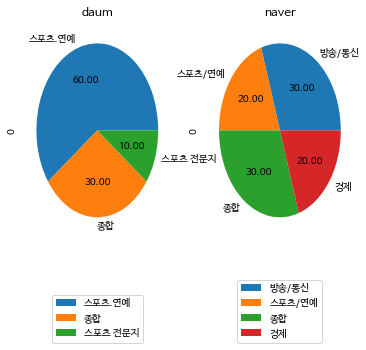

In [400]:
print ('수집기간동안 랭킹뉴스에 많이 등록된 언론사')
daumCat = list()
naverCat = list()
for idx in range(10):
    daumPressOut = intersectPress.sort_values(by='DAUM_prop',ascending=False).index[idx]
    for key in daumpressdict:
        if daumPressOut in daumpressdict[key]:
            cat1 = key
            break
    daumCat.append(cat1)
    naverPressOut = intersectPress.sort_values(by='NAVER_prop',ascending=False).index[idx]
    for key in naverpressdict:
        if naverPressOut in naverpressdict[key]:
            cat2 = key
            break
    naverCat.append(cat2)
    print ('rank : {} [ daum : {}] {} [ naver : {} ] {} '.format(idx+1, daumPressOut, cat1, naverPressOut, cat2))

ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(daumCat),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(naverCat),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

수집기간동안 랭킹뉴스에 많이 등록된 언론사
rank : 1 [ daum : OSEN] 스포츠.연예 [ naver : 연합뉴스 ] 방송/통신 
rank : 2 [ daum : 연합뉴스] 종합 [ naver : 뉴스1 ] 방송/통신 
rank : 3 [ daum : 뉴스1] 종합 [ naver : 뉴시스 ] 방송/통신 
rank : 4 [ daum : 뉴스엔] 스포츠.연예 [ naver : OSEN ] 스포츠/연예 
rank : 5 [ daum : 스포츠조선] 스포츠.연예 [ naver : 중앙일보 ] 종합 
rank : 6 [ daum : 스포티비뉴스] 스포츠 전문지 [ naver : SBS ] 종합 
rank : 7 [ daum : 엑스포츠뉴스] 스포츠.연예 [ naver : 스포츠조선 ] 스포츠/연예 
rank : 8 [ daum : TV리포트] 스포츠.연예 [ naver : 조선일보 ] 종합 
rank : 9 [ daum : 중앙일보] 종합 [ naver : 머니투데이 ] 경제 
rank : 10 [ daum : 마이데일리] 스포츠.연예 [ naver : 아시아경제 ] 경제 
rank : 11 [ daum : 뉴시스] 종합 [ naver : 한겨레 ] 종합 
rank : 12 [ daum : 스포츠서울] 스포츠.연예 [ naver : YTN ] 방송/통신 
rank : 13 [ daum : 노컷뉴스] 온라인.인터넷 [ naver : 이데일리 ] 경제 
rank : 14 [ daum : 스포탈코리아] 스포츠 전문지 [ naver : 서울신문 ] 종합 
rank : 15 [ daum : 인터풋볼] 스포츠 전문지 [ naver : 동아일보 ] 종합 
rank : 16 [ daum : 스포츠동아] 스포츠.연예 [ naver : 세계일보 ] 종합 
rank : 17 [ daum : 일간스포츠] 스포츠.연예 [ naver : TV리포트 ] 스포츠/연예 
rank : 18 [ daum : 머니투데이] 경제 [ naver : JTBC ] 방송/통신 
rank : 19 [

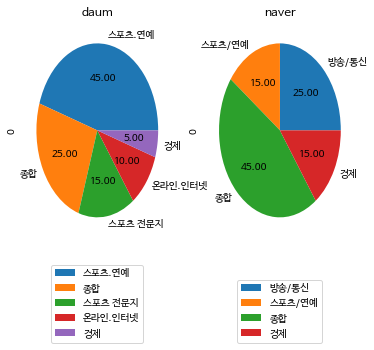

In [399]:
print ('수집기간동안 랭킹뉴스에 많이 등록된 언론사')
daumCat = list()
naverCat = list()
for idx in range(20):
    daumPressOut = intersectPress.sort_values(by='DAUM_prop',ascending=False).index[idx]
    for key in daumpressdict:
        if daumPressOut in daumpressdict[key]:
            cat1 = key
            break
    daumCat.append(cat1)
    naverPressOut = intersectPress.sort_values(by='NAVER_prop',ascending=False).index[idx]
    for key in naverpressdict:
        if naverPressOut in naverpressdict[key]:
            cat2 = key
            break
    naverCat.append(cat2)
    print ('rank : {} [ daum : {}] {} [ naver : {} ] {} '.format(idx+1, daumPressOut, cat1, naverPressOut, cat2))

ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(daumCat),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(naverCat),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

수집기간동안 랭킹뉴스에 많이 등록된 언론사
rank : 1 [ daum : OSEN] 스포츠.연예 [ naver : 연합뉴스 ] 방송/통신 
rank : 2 [ daum : 연합뉴스] 종합 [ naver : 뉴스1 ] 방송/통신 
rank : 3 [ daum : 뉴스1] 종합 [ naver : 뉴시스 ] 방송/통신 
rank : 4 [ daum : 뉴스엔] 스포츠.연예 [ naver : OSEN ] 스포츠/연예 
rank : 5 [ daum : 스포츠조선] 스포츠.연예 [ naver : 중앙일보 ] 종합 
rank : 6 [ daum : 스포티비뉴스] 스포츠 전문지 [ naver : SBS ] 종합 
rank : 7 [ daum : 엑스포츠뉴스] 스포츠.연예 [ naver : 스포츠조선 ] 스포츠/연예 
rank : 8 [ daum : TV리포트] 스포츠.연예 [ naver : 조선일보 ] 종합 
rank : 9 [ daum : 중앙일보] 종합 [ naver : 머니투데이 ] 경제 
rank : 10 [ daum : 마이데일리] 스포츠.연예 [ naver : 아시아경제 ] 경제 
rank : 11 [ daum : 뉴시스] 종합 [ naver : 한겨레 ] 종합 
rank : 12 [ daum : 스포츠서울] 스포츠.연예 [ naver : YTN ] 방송/통신 
rank : 13 [ daum : 노컷뉴스] 온라인.인터넷 [ naver : 이데일리 ] 경제 
rank : 14 [ daum : 스포탈코리아] 스포츠 전문지 [ naver : 서울신문 ] 종합 
rank : 15 [ daum : 인터풋볼] 스포츠 전문지 [ naver : 동아일보 ] 종합 
rank : 16 [ daum : 스포츠동아] 스포츠.연예 [ naver : 세계일보 ] 종합 
rank : 17 [ daum : 일간스포츠] 스포츠.연예 [ naver : TV리포트 ] 스포츠/연예 
rank : 18 [ daum : 머니투데이] 경제 [ naver : JTBC ] 방송/통신 
rank : 19 [

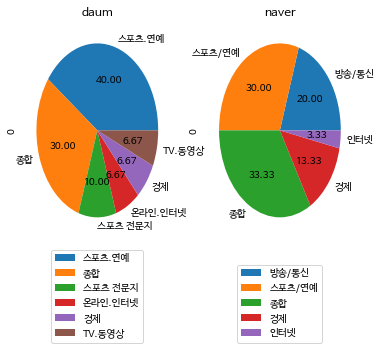

In [398]:
print ('수집기간동안 랭킹뉴스에 많이 등록된 언론사')
daumCat = list()
naverCat = list()
for idx in range(30):
    daumPressOut = intersectPress.sort_values(by='DAUM_prop',ascending=False).index[idx]
    for key in daumpressdict:
        if daumPressOut in daumpressdict[key]:
            cat1 = key
            break
    daumCat.append(cat1)
    naverPressOut = intersectPress.sort_values(by='NAVER_prop',ascending=False).index[idx]
    for key in naverpressdict:
        if naverPressOut in naverpressdict[key]:
            cat2 = key
            break
    naverCat.append(cat2)
    print ('rank : {} [ daum : {}] {} [ naver : {} ] {} '.format(idx+1, daumPressOut, cat1, naverPressOut, cat2))

ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(daumCat),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax1)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(naverCat),orient='index').plot(kind='pie',subplots=True,autopct='%.2f', fontsize=10, ax=ax2)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

In [519]:
import Database_Handler as dh
mongodb = dh.ToMongoDB(*dh.AWS_MongoDB_Information())
dbname = 'hy_db'
useDb = dh.Use_Database(mongodb, dbname)
commentsCollection = dh.Use_Collection(useDb, 'comments')
daumComments = commentsCollection.find({'site':'daum'})
numDaumComments = daumComments.count()
naverComments = commentsCollection.find({'site':'Naver'})
numNaverComments = naverComments.count()

In [543]:
naver_comment = naver_df.groupby(['press']).mean()['number_of_comment'][rawNaverIndex]
daum_comment = daum_df.groupby(['press']).mean()['number_of_comment'][rawNaverIndex]

naverGroup = naver_df.groupby('press').sum()['number_of_comment'][intersectNaver]
rawNaverIndex = naverGroup.index
naverGroup.rename(index=xdict,inplace = True)
naverGroup = naverGroup.groupby(naverGroup.index).sum()
daumGroup = daum_df.groupby('press').sum()['number_of_comment'][intersectDaum]

intersectPress = pd.DataFrame({'DAUM':daumGroup,
                               'DAUM_prop':daumGroup.divide(daum_df['number_of_comment'].sum())*100,
                               'NAVER':naverGroup, 
                               'NAVER_prop':naverGroup.divide(naver_df['number_of_comment'].sum())*100}).fillna(0)
intersectPress = intersectPress.sort_values(by='NAVER',ascending=False)
intersectPress.sum(axis = 0)

DAUM          2.972813e+06
DAUM_prop     9.792697e+01
NAVER         6.179665e+06
NAVER_prop    9.730158e+01
dtype: float64

In [544]:
top5 = intersectPress[:5]
top5.loc['합'] = top5.sum()
top5

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,DAUM,DAUM_prop,NAVER,NAVER_prop
연합뉴스,579577.0,19.091755,1612547.0,25.390271
뉴스1,309968.0,10.210607,673863.0,10.610273
뉴시스,161754.0,5.328313,416111.0,6.551853
SBS,91479.0,3.013395,280773.0,4.420896
중앙일보,135934.0,4.477781,203550.0,3.204985
합,1278712.0,42.121851,3186844.0,50.178278


In [545]:
top10 = intersectPress[:10]
top10.loc['합'] = top10.sum()
top10

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,DAUM,DAUM_prop,NAVER,NAVER_prop
연합뉴스,579577.0,19.091755,1612547.0,25.390271
뉴스1,309968.0,10.210607,673863.0,10.610273
뉴시스,161754.0,5.328313,416111.0,6.551853
SBS,91479.0,3.013395,280773.0,4.420896
중앙일보,135934.0,4.477781,203550.0,3.204985
머니투데이,129176.0,4.255166,200415.0,3.155623
OSEN,67954.0,2.238462,183792.0,2.893887
노컷뉴스,135929.0,4.477616,168799.0,2.657815
이데일리,74039.0,2.438907,150716.0,2.373091
JTBC,79049.0,2.603941,145639.0,2.293151


In [546]:
top20 = intersectPress[:20]
top20.loc['합'] = top20.sum()
top20

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,DAUM,DAUM_prop,NAVER,NAVER_prop
연합뉴스,579577.0,19.091755,1612547.0,25.390271
뉴스1,309968.0,10.210607,673863.0,10.610273
뉴시스,161754.0,5.328313,416111.0,6.551853
SBS,91479.0,3.013395,280773.0,4.420896
중앙일보,135934.0,4.477781,203550.0,3.204985
머니투데이,129176.0,4.255166,200415.0,3.155623
OSEN,67954.0,2.238462,183792.0,2.893887
노컷뉴스,135929.0,4.477616,168799.0,2.657815
이데일리,74039.0,2.438907,150716.0,2.373091
JTBC,79049.0,2.603941,145639.0,2.293151


In [547]:
naver_comment = naver_df.groupby(['press']).mean()['number_of_crawled_comment'][rawNaverIndex]
daum_comment = daum_df.groupby(['press']).mean()['number_of_crawled_comment'][rawNaverIndex]

naverGroup = naver_df.groupby('press').sum()['number_of_crawled_comment'][intersectNaver]
rawNaverIndex = naverGroup.index
naverGroup.rename(index=xdict,inplace = True)
naverGroup = naverGroup.groupby(naverGroup.index).sum()
daumGroup = daum_df.groupby('press').sum()['number_of_crawled_comment'][intersectDaum]

intersectPress = pd.DataFrame({'DAUM':daumGroup,
                               'DAUM_prop':daumGroup.divide(daum_df['number_of_crawled_comment'].sum())*100,
                               'NAVER':naverGroup, 
                               'NAVER_prop':naverGroup.divide(naver_df['number_of_crawled_comment'].sum())*100}).fillna(0)
intersectPress = intersectPress.sort_values(by='NAVER',ascending=False)
intersectPress.sum(axis = 0)

DAUM          2.466032e+06
DAUM_prop     9.794077e+01
NAVER         5.409799e+06
NAVER_prop    9.715718e+01
dtype: float64

In [548]:
top5 = intersectPress[:5]
top5.loc['합'] = top5.sum()
top5

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,DAUM,DAUM_prop,NAVER,NAVER_prop
연합뉴스,485436.0,19.279545,1392386.0,25.006528
뉴스1,261855.0,10.399816,587114.0,10.544262
뉴시스,136466.0,5.419875,365625.0,6.566435
SBS,76317.0,3.031001,244059.0,4.383173
중앙일보,110958.0,4.406801,178796.0,3.211083
합,1071032.0,42.537038,2767980.0,49.711481


In [549]:
top10 = intersectPress[:10]
top10.loc['합'] = top10.sum()
top10

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,DAUM,DAUM_prop,NAVER,NAVER_prop
연합뉴스,485436.0,19.279545,1392386.0,25.006528
뉴스1,261855.0,10.399816,587114.0,10.544262
뉴시스,136466.0,5.419875,365625.0,6.566435
SBS,76317.0,3.031001,244059.0,4.383173
중앙일보,110958.0,4.406801,178796.0,3.211083
OSEN,55197.0,2.192201,167789.0,3.013403
머니투데이,108620.0,4.313945,166669.0,2.993289
노컷뉴스,101503.0,4.031287,151173.0,2.714988
이데일리,60828.0,2.415841,131203.0,2.356338
스포츠조선,25956.0,1.030867,128554.0,2.308763


In [550]:
top20 = intersectPress[:20]
top20.loc['합'] = top20.sum()
top20

/Users/hyunyoun/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,DAUM,DAUM_prop,NAVER,NAVER_prop
연합뉴스,485436.0,19.279545,1392386.0,25.006528
뉴스1,261855.0,10.399816,587114.0,10.544262
뉴시스,136466.0,5.419875,365625.0,6.566435
SBS,76317.0,3.031001,244059.0,4.383173
중앙일보,110958.0,4.406801,178796.0,3.211083
OSEN,55197.0,2.192201,167789.0,3.013403
머니투데이,108620.0,4.313945,166669.0,2.993289
노컷뉴스,101503.0,4.031287,151173.0,2.714988
이데일리,60828.0,2.415841,131203.0,2.356338
스포츠조선,25956.0,1.030867,128554.0,2.308763


## 네이버와 다음중 한군데만 등록된 언론사

In [449]:
def DaumCat(x):
    cat1 = None
    for key in daumpressdict:
        if x in daumpressdict[key]:
            cat1 = key
            break
    if cat1==None:
        cat1 = '기타'
    return cat1
def NaverCat(x):
    cat1 = None
    for key in naverpressdict:
        if x in naverpressdict[key]:
            cat1 = key
            break
    if cat1==None:
        cat1 = '기타'
    return cat1

In [466]:
onlyNaver = naver_df.groupby('press').count()['id']
onlyNaver = onlyNaver[onlyNaver.index.difference(intersectNaver.values)]
onlyNaver = pd.DataFrame({'count':onlyNaver, 'prop':onlyNaver.divide(naver_df.shape[0])})
onlyNaver['category'] = onlyNaver.index.map(lambda x: NaverCat(x))
onlyNaver.sort_values(by='count',ascending=False,inplace = True)
onlyDaum = daum_df.groupby('press').count()['id']
onlyDaum = onlyDaum[onlyDaum.index.difference(intersectDaum.values)]
onlyDaum = pd.DataFrame({'count':onlyDaum, 'prop':onlyDaum.divide(daum_df.shape[0])})
onlyDaum['category'] = onlyDaum.index.map(lambda x: DaumCat(x))
onlyDaum.sort_values(by='count',ascending=False,inplace = True)

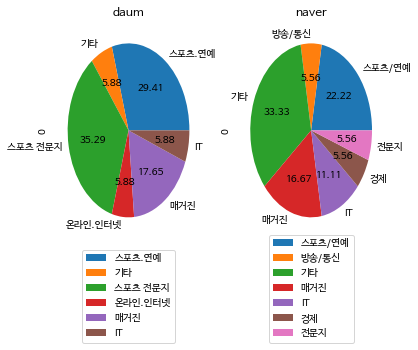

In [475]:
ax1 = plt.subplot(1, 2, 1)
pd.DataFrame.from_dict(Counter(onlyDaum['category']), orient='index')[0].plot(kind = 'pie',autopct='%.2f', fontsize=10)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax1.set_title('daum')
ax2 = plt.subplot(1, 2, 2)
pd.DataFrame.from_dict(Counter(onlyNaver['category']), orient='index')[0].plot(kind = 'pie',autopct='%.2f', fontsize=10)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.5))
ax2.set_title('naver')
plt.show()

In [478]:
onlyDaum[['count','prop']].sum()

count    303.000000
prop       0.064168
dtype: float64

In [479]:
onlyNaver[['count','prop']].sum()

count    288.000000
prop       0.037495
dtype: float64